# Compare both devices
Here I will compare the measurements of Solexperts with the measurements made with the Lios device.

The data of Solexperts have been measured directly in a loop. So the temperatures of the single channel measurements are not avaible. In our measurements I avearage the results from the DTS device. Therfore I also delete a few datapoints (about 8, depending on channel), otherwise a positions, wich is in the watertank would be aveargaed with a position not in watertank. It still needs to be optimized which positions I delete. I wanted to mention it here, but I dont think you have to bother with it.

## Summary Differences
* The measurements of Solexperts have a longer cable. Our device automaticly detects 1708 m of cable length in channel 5 and 6. Their result have a length of 1738 m --> evntl nachfragen, ob die so vom Gerät bestimmt wurden oder nachträglich bearbeitet.
* Watertank Temperature is different, about 1.5 °C
  * Our measurements were wrong due to wrong measurements of the watertank temperature
  * in heating phases, my correction of the DTS values is not very suitable, because the PT sensors measures always a cooler temperature than the DTS because the DTS is closer to the heat source.
* Data of Solexperts do not have strong peaks at bend-point of cable. I guess thats due to different internal processing of the data?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import numpy as np
import pickle
from datetime import timedelta
import math

from my_func_mvw.functions_import_my_database import import_my_database_pickle, import_my_database_csv
from my_func_mvw.functions import read_pickle, find_nearest_date
%load_ext autoreload
%autoreload 2

importer = "pickle" #at the moment only pickle is implemented
path_to_my_database = r"..\Alsdorf\Daten\my_database" #".\\"
plot_save = True #True False

print("Some Version information of the imported packages")
print(f"pandas version: {pd.__version__}")
print(f"pickle version: {pickle.format_version}")
# Output from Mathis:
# Some Version information of the imported packages
# pandas: 1.2.3
# pickle: 4.0
# Python 3.8.8

Some Version information of the imported packages
pandas version: 1.3.2
pickle version: 4.0


In [2]:
# import solexperts data
# 20s
path_to_solexperts = path_to_my_database + "\Solexperts_EGRT"
filename=r"\alle Messungen_TEMP.txt"

#encoding= 'unicode_escape': for reading non asci characters
temp_sol = pd.read_csv(path_to_solexperts + filename, delimiter="\t", index_col=0, encoding= 'unicode_escape')
temp_sol.index.names = ["Length [m]"]
temp_sol.index = temp_sol.index.astype(int)
temp_sol.columns.names = ["Date"]
temp_sol.columns= pd.to_datetime(temp_sol.columns)
temp_sol = temp_sol.T

In [3]:
# import solexperts t_logger
filename = "\wagoTemperatur_korigiert.txt"
tlogger_sol = pd.read_csv(path_to_solexperts + filename, delimiter="\t", index_col=0)
tlogger_sol.columns.names = ["Dates"]
tlogger_sol.columns= pd.to_datetime(tlogger_sol.columns)
tlogger_sol.index=["Watertank"]
tlogger_sol.index.names = [""]
tlogger_sol = tlogger_sol.T

In [4]:
# import my_database
if importer == "pickle":
    data_2021 = import_my_database_pickle(2021,path_to_my_database + r"\pickle")
if importer == "csv":
    data_2021 = import_my_database_csv(2021, path_to_my_database + r"\csv")

# import my final temperatures
my_final_mean_78 = read_pickle(path_to_my_database + "\shaft_final_temperature\egrt_cable\pickle\Schacht_7and8_down")
my_final_14={}
for chan in ["1","2","3","4"]:
    my_final_14[chan] = read_pickle(path_to_my_database + f"\\shaft_final_temperature\\old_cable\\pickle\\Schacht_chan_{chan}")

my_final_mean_both = read_pickle(path_to_my_database + "\mean_ch5-8_constshift")
my_final_mean_56 = my_final_mean_both["5and6"]
my_final_mean_78 = my_final_mean_both["7and8"]

data_ch58_processed_constshifted=read_pickle(path_to_my_database + "\data_ch5-8_processed_constshifted")

data_ch58_processed_averagefirst=read_pickle(path_to_my_database + "\..\my_database_additional_local\mean_ch5-8_constshift_averagefirst")

# import my tlogger
df_Tlogger_PT100  = read_pickle(path_to_my_database + "/t_logger_watertank/Tlogger_PT100_outdated")
df_Tlogger_PT1000 = read_pickle(path_to_my_database + "/t_logger_watertank/Tlogger_PT1000")

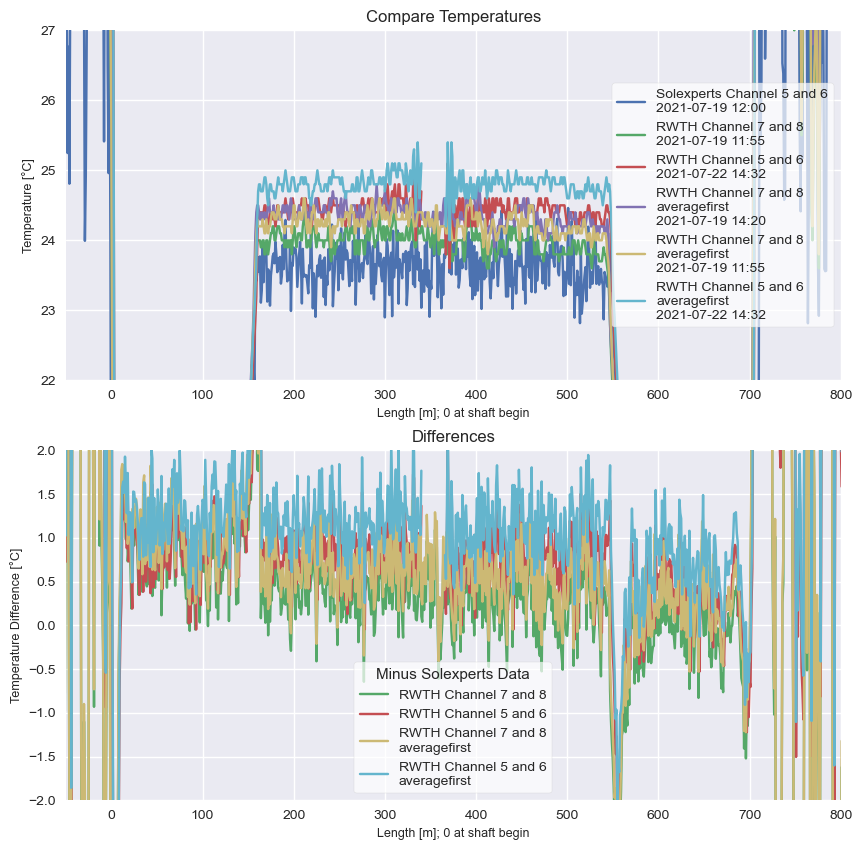

In [5]:
# our data has large data gaps due to watertank temp recording problems. At this dates we have measurements.
# --> mit constshift ist es egal
plot_mean_channels=True
plot_averagefirst=True
plot_single_channels=False
plot_old_channels=False
plot_chan78_close56=True


# dates outside the egrt segment fit better!!!!!!!!!!!!!!!!!!!
date_name_78, iloc_78 = find_nearest_date("19.07.2021 12:00:00",my_final_mean_78.index)
date_name_56, iloc_56 = find_nearest_date("19.07.2021 12:00:00",my_final_mean_56.index)
date_name_sol, iloc_sol = find_nearest_date("19.07.2021 12:00:00",temp_sol.index)
date_name_78_close56, iloc_78_close56 = find_nearest_date("19.07.2021 14:32:00",my_final_mean_78.index) #close to chan56


data_one_date_sol = temp_sol.iloc[iloc_sol]
my_data_one_date_78 = my_final_mean_78.iloc[iloc_78]
my_data_one_date_78_close56 = data_ch58_processed_averagefirst["7and8"].iloc[iloc_78_close56]
my_data_one_date_56 = my_final_mean_56.iloc[iloc_56+5] # dont use the first measurement, after measurement stopp
my_data_one_date_78_averagefirst = data_ch58_processed_averagefirst["7and8"].iloc[iloc_78]
my_data_one_date_56_averagefirst = data_ch58_processed_averagefirst["5and6"].iloc[iloc_56+5]

# const shift data, for single channels
iloc_constshift={}
date_name_constshift={}
for chan in ["5","6","7","8"]:
    date_name_constshift[chan], iloc_constshift[chan] = find_nearest_date("19.07.2021 12:00:00",data_ch58_processed_constshifted[chan].index)

offset_RWTH=504 # 506 bei shaft extract
offset_solexperts=514 #laut Bericht ca. 511
fig,axs = plt.subplots(2,1,figsize=(10,10))

date = data_one_date_sol.name
axs[0].plot(data_one_date_sol.index - offset_solexperts, data_one_date_sol.values, label=f"Solexperts Channel 5 and 6\n{str(date)[:-3]}")#,linewidth=5)
if plot_mean_channels:
    date = my_data_one_date_78.name
    x=my_data_one_date_78[:1708].index - offset_RWTH
    line_mean, = axs[0].plot(x,my_data_one_date_78[:1708].values, label=f"RWTH Channel 7 and 8\n{str(date)[:-3]}") #\nconstant shifted mean
    # SEHR SUBOPTIMAL GELÖST!!!!!!!!!!!!
    length=len(my_data_one_date_78[offset_RWTH:1708].values) #1708
    y=my_data_one_date_78[offset_RWTH-200:1708].values - data_one_date_sol.values[offset_solexperts-200:-21]
    axs[1].plot(x[offset_RWTH-200:],y, label=f"RWTH Channel 7 and 8", color=line_mean.get_color())
    date = my_data_one_date_56.name
    x=my_data_one_date_56.index - offset_RWTH
    line_mean, = axs[0].plot(x,my_data_one_date_56.values, label=f"RWTH Channel 5 and 6\n{str(date)[:-3]}") #\nconstant shifted mean
    # SEHR SUBOPTIMAL GELÖST!!!!!!!!!!!!
    length=len(my_data_one_date_78[offset_RWTH:1708].values) #1708
    y=my_data_one_date_56.values[offset_RWTH-200:] - data_one_date_sol.values[offset_solexperts-200:-28]
    axs[1].plot(x[offset_RWTH-200:],y, label=f"RWTH Channel 5 and 6", color=line_mean.get_color())

if plot_chan78_close56:
    date = my_data_one_date_78_close56.name
    x=my_data_one_date_78_close56[:1708].index - offset_RWTH
    line_mean, = axs[0].plot(x,my_data_one_date_78_close56[:1708].values, label=f"RWTH Channel 7 and 8\naveragefirst\n{str(date)[:-3]}") #\nconstant shifted mean
    # # SEHR SUBOPTIMAL GELÖST!!!!!!!!!!!!
    # length=len(my_data_one_date_78_close56[offset_RWTH:1708].values) #1708
    # y=my_data_one_date_78_close56[offset_RWTH-200:1708].values - data_one_date_sol.values[offset_solexperts-200:-21]
    # axs[1].plot(x[offset_RWTH-200:],y, label=f"RWTH Channel 7 and 8", color=line_mean.get_color())

if plot_single_channels:
    for chan in ["5","6","7","8"]:
        date = date_name_constshift[chan]
        data_cshift = data_ch58_processed_constshifted[chan]
        if chan == "7" or chan == "8":
            data_one_date = data_cshift[data_cshift.columns[:1708]].iloc[iloc_constshift[chan]]
            data_one_date_2 = data_cshift[data_cshift.columns[1708:]].iloc[iloc_constshift[chan]]
        elif chan == "5" or chan == "6":
            data_one_date = data_cshift.iloc[iloc_constshift[chan]+5] # dont use the first measurement, after measurement stopp
        axs[0].plot(data_one_date.index,data_one_date.values, label=f"RWTH Channel {chan}\n{str(date)[:-3]}")
        # Folgendes erkennt man keine besserung
        # if chan=="7" or chan=="8":
        #     axs[0].plot(data_one_date_2.index-1708,data_one_date_2.values, label=f"OTHER SIDE Temp. Mathis Channel {chan}\n{date}")

if plot_old_channels:
    for chan in ["2","3"]: #["1","2","3","4"]
        data=my_final_14[chan]
        date_name_14, date_index_14 = find_nearest_date("19.07.2021 12:00:00",data.index)
        data=data.iloc[date_index_14]
        line_old, =axs[0].plot(data.index[:350],data.values[:350], label=f"RWTH Channel {chan}\n{date_name_14[:-3]}")
        # SEHR SUBOPTIMAL GELÖST!!!!!!!!!!!!
        length=len(my_data_one_date_78[offset_RWTH:1708].values) #1708
        y=data.values[:350] - data_one_date_sol.values[offset_solexperts:offset_solexperts+350]
        axs[1].plot(data.index[:350],y, label=f"RWTH Channel {chan}",color=line_old.get_color())
    
if plot_averagefirst: 
    date = my_data_one_date_78.name
    x=my_data_one_date_78_averagefirst[:1708].index - offset_RWTH
    line_mean, = axs[0].plot(x,my_data_one_date_78_averagefirst[:1708].values, label=f"RWTH Channel 7 and 8\naveragefirst\n{str(date)[:-3]}") #\nconstant shifted mean
    # SEHR SUBOPTIMAL GELÖST!!!!!!!!!!!!
    length=len(my_data_one_date_78_averagefirst[offset_RWTH:1708].values) #1708
    y=my_data_one_date_78_averagefirst[offset_RWTH-200:1708].values - data_one_date_sol.values[offset_solexperts-200:-21]
    axs[1].plot(x[offset_RWTH-200:],y, label=f"RWTH Channel 7 and 8\naveragefirst", color=line_mean.get_color())
    date = my_data_one_date_56_averagefirst.name
    x=my_data_one_date_56_averagefirst.index - offset_RWTH
    line_mean, = axs[0].plot(x,my_data_one_date_56_averagefirst.values, label=f"RWTH Channel 5 and 6\naveragefirst\n{str(date)[:-3]}") #\nconstant shifted mean
    # SEHR SUBOPTIMAL GELÖST!!!!!!!!!!!!
    length=len(my_data_one_date_78_averagefirst[offset_RWTH:1708].values) #1708
    y=my_data_one_date_56_averagefirst.values[offset_RWTH-200:] - data_one_date_sol.values[offset_solexperts-200:-28]
    axs[1].plot(x[offset_RWTH-200:],y, label=f"RWTH Channel 5 and 6\naveragefirst", color=line_mean.get_color())


# Assecoirs
label_fontsize=9
for ax in axs:
    ax.set_xlabel("Length [m]; 0 at shaft begin",fontsize=label_fontsize)
    ax.set_xlim(-50,800) #-50,800
legend = axs[0].legend(fontsize=10, title_fontsize=11,frameon=True)
legend.get_frame().set_facecolor("white")
legend.get_frame().set_alpha(0.7)
legend = axs[1].legend(fontsize=10, title_fontsize=11,frameon=True, title="Minus Solexperts Data")
legend.get_frame().set_facecolor("white")
legend.get_frame().set_alpha(0.7)
axs[0].set_ylabel("Temperature [°C]",fontsize=label_fontsize)
axs[0].set_ylim([22,27])
axs[0].set_title("Compare Temperatures")
# plt.xlim([0,100])
# plt.vlines(27,22,25,label="watertank sol", color="black",linestyle="--")
# plt.vlines(25,22,25,label="watertank rwth", color="pink",linestyle="--")
axs[1].set_title("Differences")
axs[1].set_ylabel("Temperature Difference [°C]",fontsize=label_fontsize)
axs[1].set_ylim(-2,2)

plt.show()

# Interpretation
* mit const shift ist Unterschied 0.5 bzw 1°C, werde ich jetzt so hinnehmen
* liegt unterschied an unterschiedlicher Wassertanktemperatur? --> nicht nur
--> hier passt ein shift von 2°C besser --> liegt nicht nur an Heizphase 
* Wassertank und DTS Temp. stimmen eh nicht überein, also ist meine Korrektur unserer Daten nicht passend.
    * Vergleiche nächster Plot, in Heizphasen misst PT_Sensor kältere Temperaturen und in Abkühlphasen wärmere
    --> bei diesem Messpunkt ist der Einfluss gering (max 0.3 °C)

    * Es gibt also eine unerklärte Differenz von mind 0.3 °C (max 0.6 °C), ist ungefähr im Toleranz bereich aber eigentlich etwas hoch
    * bei constshift spielt das keine Rolle

* bei meinen Messungen ist mean78 immer etwas kühler als mean56: ca. 0.3 °C; hier ist es genau anders rum

* Am Wassertank sind beide noch gleich in Schacht ist Unterschied zu sehen.
    * das ist mein shiftfirst Ansatz also sind sie nicht beide genau gleich.
    * Man könnte argumentieren, dass ich meine Werte etwas wärmer machen muss anhand von Abweichung im Wassertank --> wäre für den Plot hier kontraproduktiv

* ältere Datums von mir passen deutlich besser (channel 56 immer zu warm)

Ich könnte mir vorstellen, dass der Unterschied vom Gerät selbst kommt?
Bin mir nicht sicher, ob das irgendwie durch anderes verschieben oder mitteln verbessert werden kann.

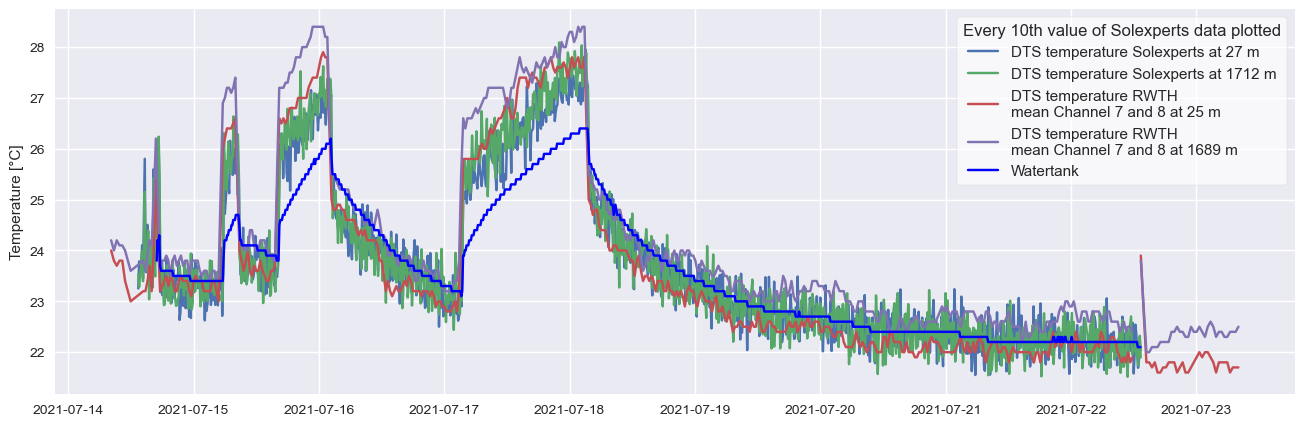

In [15]:
# plot Solexperts temperatures
x=10
plt.figure(figsize=(16,5))
watertank_pos=27
plt.plot(temp_sol[temp_sol.columns[watertank_pos]][::x],label=f"DTS temperature Solexperts at {watertank_pos} m")
watertank_pos=1712
plt.plot(temp_sol[temp_sol.columns[watertank_pos]][::x],label=f"DTS temperature Solexperts at {watertank_pos} m")

data=my_final_mean_78[25]
#data=data_2021["7"][25]
# timedelta is also needed for unavearaged data: data_2021
# is this datemissmatch only due to other sampling / measurement sequence and averaging?
#Nehme ich einfach mal an
plt.plot(data[1920:2440].index+timedelta(minutes=80),data[1920:2440].values, label=f"DTS temperature RWTH\nmean Channel 7 and 8 at {data.name} m")
data=my_final_mean_78[1689]
#data=data_2021["7"][1689]
plt.plot(data[1920:2440].index+timedelta(minutes=80),data[1920:2440].values, label=f"DTS temperature RWTH\nmean Channel 7 and 8 at {data.name} m")

plt.plot(tlogger_sol.index[::x],tlogger_sol.values[::x],label="Watertank", color="blue")

#plt.title("Water Tank Temperature During EGRT", fontsize=13)
#plt.xlabel("Date")
plt.ylabel("Temperature [°C]")
legend = plt.legend(fontsize=11, title_fontsize=12,frameon=True, loc="upper right",title=f"Every {x}th value of Solexperts data plotted")
legend.get_frame().set_facecolor("white")
legend.get_frame().set_alpha(0.7) #not supported with eps

if plot_save:
    plt.savefig("pictures\watertank_temp_during_egrt.png")
    plt.savefig(r"..\Masterthesis_tex\figs\chap4\watertank_temp_during_egrt.pdf", format="pdf",bbox_inches="tight")
plt.show()

# Vorallem in Hezphasen können die Temperaturen nicht wirklich verglichen werden, da die DTS MEssungen näher an der Wärmequelle sind.

## Interpretation
* Channel 8 hat einen stärkeren Trend als Channel 7 bei unseren Daten. Deswegen
  * Die Länge der gemittelten Daten ist wie bei Kanal 8.

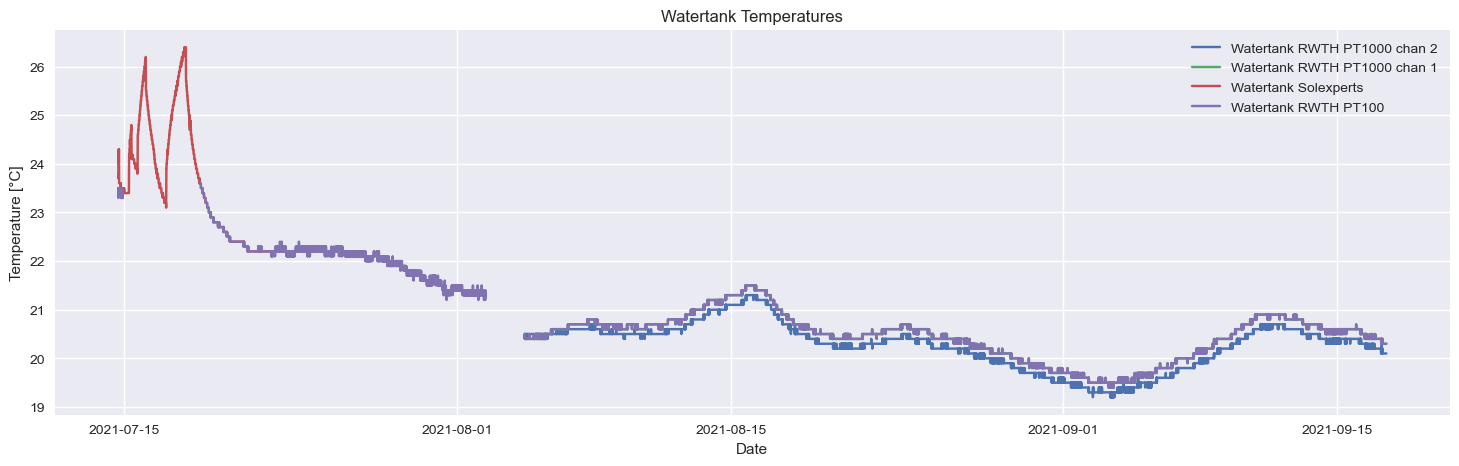

In [7]:
# plot watertank temperatures
plt.figure(figsize=(18,5))
plt.plot(df_Tlogger_PT1000["Channel2_PT1000"].index,df_Tlogger_PT1000["Channel2_PT1000"].values,label="Watertank RWTH PT1000 chan 2")
plt.plot(df_Tlogger_PT1000["Channel1_PT1000"].index,df_Tlogger_PT1000["Channel1_PT1000"].values,label="Watertank RWTH PT1000 chan 1")
plt.plot(tlogger_sol.index,tlogger_sol.values,label="Watertank Solexperts")
plt.plot(df_Tlogger_PT100["Channel1-Watertank_PT100"].index[15900:],df_Tlogger_PT100["Channel1-Watertank_PT100"].values[15900:],
    label="Watertank RWTH PT100")
# plt.scatter(df_Tlogger_PT100["Channel1-Watertank_PT100"].index[15900:],df_Tlogger_PT100["Channel1-Watertank_PT100"].values[15900:]-1.5,
#     label="Watertank RWTH PT100 shifted: -1.5")

plt.title("Watertank Temperatures")
plt.xlabel("Date")
plt.ylabel("Temperature [°C]")
plt.legend()
plt.show()

#plt.savefig("pictures/watertank_compare.png")
# PT100 enthält im moment Daten von Solexperts, alte geshiftete Daten und PT1000 Daten

# Analyze raw data
I could not yet reconstruct the temperature values from solexprts out of their raw data

In [8]:
# import raw data
filename="\\alle_Messungen_DAEMPFUNG.txt"
raw_sol = pd.read_csv(path_to_solexperts + filename, delimiter="\t", index_col=0, na_values=[" "], dtype=float)
raw_sol.index.names = ["Length [m]"]
raw_sol.index = raw_sol.index.astype(int)
raw_sol.columns.names = ["Date"]
raw_sol.columns= pd.to_datetime(raw_sol.columns)
raw_sol = raw_sol.T
# Why is number of columns different to temperature?

#I_+ / I_-
# *-1 to egt the value of I_- / I_+

In [9]:
# seems not to be the solution
raw_sol_stretched=raw_sol.T.reindex(raw_sol.T.index.union(np.linspace(0,1644,1739)))
raw_sol_stretched=raw_sol_stretched.interpolate(method="index", axis=0)
raw_sol_stretched=raw_sol_stretched.T[np.linspace(0,1644,1739)]
raw_sol_stretched.columns=np.linspace(0,1738,1739)
raw_sol_stretched.columns=raw_sol_stretched.columns.astype(int)
#raw_sol_stretched=raw_sol_stretched.T
#raw_sol_stretched

In [10]:
# cut dataframe so it fits to raw data
x=0
col=temp_sol.columns[x:1645+x]
compare_temp_sol = temp_sol[:-47][col] #delete last dates because they are not in raw dataframe
compare_temp_sol.columns=np.arange(0,1645,1) #so column names fit to raw data
#compare_temp_sol_K = compare_temp_sol + 273.15 # macht keinen Unterschied
#compare_temp_sol

In [11]:
# Not finished - does not work good
def raw_in_temp(raw,T_ref,C):
    """"""
    T=T_ref*(1+raw/math.log(C))
    return T

from scipy.optimize import fsolve
def find_constants_for_raw_in_temp(temp_sol_array, raw_sol_array):
    """
    temp_sol_array: Two temperatures of the solexperts data
    raw_sol_array: corresponding raw values of solexperts data
    """
    #temp_sol_array=[21.732,26.158]
    #raw_sol_array=[7.288,7.184]
    def myfunction(x,temp_sol_array=temp_sol_array, raw_sol_array=raw_sol_array):#
        """x[0]: T_ref; x[1]: C"""

        array= [-1*temp_sol_array[0] + x[0] + raw_sol_array[0]*x[0]/x[1],
        -1*temp_sol_array[1] + x[0] + raw_sol_array[1]*x[0]/x[1]]

        return array

    constant_guess=[300,-8]
    constants=fsolve(myfunction, constant_guess)
    T_ref=constants[0]
    ln_C=constants[1]
    return T_ref, ln_C



331.8924615384625, -7.79864798915499


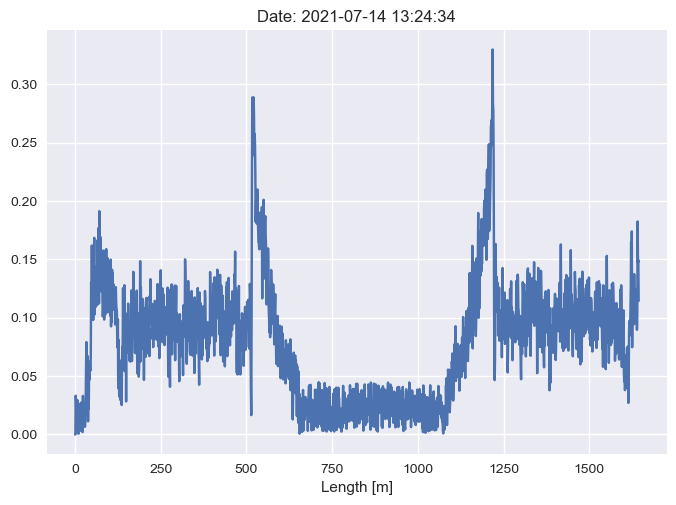

In [12]:
# use columns for constant calculation
col1=0
col2=1
date=0

temp_sol_array=np.array([compare_temp_sol.iloc[date][col1],compare_temp_sol.iloc[date][col2]])
raw_sol_array=np.array([raw_sol.iloc[date][col1],raw_sol.iloc[date][col2]])*-1
T_ref, ln_C = find_constants_for_raw_in_temp(temp_sol_array, raw_sol_array)
#(331.8924615384625, -7.79864798915499)
print(f"{T_ref}, {ln_C}")

# do calculations of constants for every date seperate
T_ref, ln_C = find_constants_for_raw_in_temp(temp_sol_array, raw_sol_array)

C=math.e**ln_C
temp_sol_calc_me = raw_in_temp(-1*raw_sol,T_ref,C) #*-1 because solexperts gave the raw data flipped on ln() compared to the used function
temp_sol_calc_me

#they somehow stretched their results?


diff = abs(temp_sol_calc_me - compare_temp_sol)
date=0
diff.iloc[date].plot()
plt.title(f"Date: {diff.iloc[date].name}")
plt.show()

# looks like raw data and temp dataframes of solexperts do not match together.
# Maybe I did not correctly math the length

349.62669717387786, -7.771029513331886


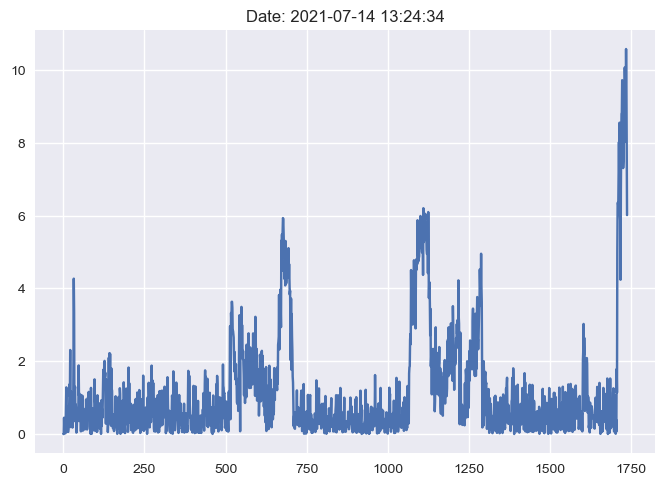

In [13]:
# Use stretched raw data
raw_sol_stretched


# use columns for constant calculation
col1=0
col2=1
date=0

temp_sol_array=np.array([temp_sol.iloc[date][col1],temp_sol.iloc[date][col2]])
raw_sol_array=np.array([raw_sol_stretched.iloc[date][col1],raw_sol_stretched.iloc[date][col2]])*-1
T_ref, ln_C = find_constants_for_raw_in_temp(temp_sol_array, raw_sol_array)
#(331.8924615384625, -7.79864798915499)
print(f"{T_ref}, {ln_C}")

# do calculations of constants for every date seperate
T_ref, ln_C = find_constants_for_raw_in_temp(temp_sol_array, raw_sol_array)

C=math.e**ln_C
temp_sol_calc_me = raw_in_temp(-1*raw_sol_stretched,T_ref,C) #*-1 because solexperts gave the raw data flipped on ln() compared to the used function
temp_sol_calc_me


diff = abs(temp_sol_calc_me - temp_sol)
date=0
diff.iloc[date].plot()
plt.title(f"Date: {diff.iloc[date].name}")
plt.show()

# Try the same with stretching the calculated temperatures

In [14]:
# how to cut the dataframe best:
analyse_cut=False
if analyse_cut:
    diff_mean={}
    for x in np.arange(0,95,1):
        #print(x)
        #x=94 #cut dataframe columns different, need to be cutted so they fit to raw datraframe
        col=temp_sol.columns[x:1645+x]
        compare_temp_sol = temp_sol[:-47][col] #delete last dates because they are not in raw dataframe
        compare_temp_sol.columns=np.arange(0,1645,1) #so column names fit to raw data
        compare_temp_sol

        # calc the temp from raw data
        temp_sol_array=np.array([compare_temp_sol.iloc[0][0],compare_temp_sol.iloc[0][1]])
        raw_sol_array=np.array([raw_sol.iloc[0][0],raw_sol.iloc[0][1]])*-1
        T_ref, ln_C = find_constants_for_raw_in_temp(temp_sol_array, raw_sol_array)
        #print(f"{T_ref},{ln_C}")
        C=math.e**ln_C

        try: # a lot of math domain errors
            temp_sol_calc_me = raw_in_temp(-1*raw_sol,T_ref,C) #*-1 because solexperts gave the raw data flipped on ln() compared to the used function

            # difference of my calculations from raw data to solexperts temperature
            diff = abs(temp_sol_calc_me - compare_temp_sol)
            diff_mean[x]=diff.iloc[0].mean()
        except:
            diff_mean[x]=np.nan

    diff_mean
    # from this analysis x=0 is by far the best option for cutting the dataframe